##  MBA Ciência de Dados
### Tratamento de dados desbalanceados em classificação binária com algoritmos em Python e aplicação em Marketing
#### Ramon Barbosa Rosa
##### Dezembro 2020

In [1]:
#!pip install -U scikit-learn
#!pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import timeit
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, scale
from scipy import stats #Testes de hipóteses
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

In [3]:
path = r'D:\Documentos D\ESTUDOS\Arquivos MBA Ciência de Dados - USP (G Drive)\12-TCC\Datasets\bank-additional (UCI)'
path_for_save = r'D:\Documentos D\ESTUDOS\Arquivos MBA Ciência de Dados - USP (G Drive)\12-TCC'
file = r'\bank-additional-full.xlsx'
data = pd.read_excel(f'{path}{file}', engine='openpyxl')
data.columns = map(str.upper, data.columns)
data.head()

,AGE,JOB,MARITAL,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,...,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,EMP.VAR.RATE,CONS.PRICE.IDX,CONS.CONF.IDX,EURIBOR3M,NR.EMPLOYED,Y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,11,93994,-364,4857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,11,93994,-364,4857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,11,93994,-364,4857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,11,93994,-364,4857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,11,93994,-364,4857,5191,no


# 1 - Descriptive analysis and data preprocessing

## 1.1 - Data general info

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AGE             41188 non-null  int64 
 1   JOB             41188 non-null  object
 2   MARITAL         41188 non-null  object
 3   EDUCATION       41188 non-null  object
 4   DEFAULT         41188 non-null  object
 5   HOUSING         41188 non-null  object
 6   LOAN            41188 non-null  object
 7   CONTACT         41188 non-null  object
 8   MONTH           41188 non-null  object
 9   DAY_OF_WEEK     41188 non-null  object
 10  DURATION        41188 non-null  int64 
 11  CAMPAIGN        41188 non-null  int64 
 12  PDAYS           41188 non-null  int64 
 13  PREVIOUS        41188 non-null  int64 
 14  POUTCOME        41188 non-null  object
 15  EMP.VAR.RATE    41188 non-null  int64 
 16  CONS.PRICE.IDX  41188 non-null  int64 
 17  CONS.CONF.IDX   41188 non-null  int64 
 18  EURIBO

## 1.2 - Convert target variable (y) to binary

In [5]:
#Convert 'y' (label) to numeric
data.rename(columns={'Y': 'TARGET'}, inplace=True) 
rule = {'yes':1, 'no':0}
data['TARGET'].replace(rule, inplace=True)


## 1.3 - Descriptive statistcs

In [6]:
descriptive_before = round(data.describe().T, 3)
descriptive_before.to_excel(f'{path_for_save}/descriptive before.xlsx', sheet_name='descriptive before')
descriptive_before

,count,mean,std,min,25%,50%,75%,max
AGE,41188.0,40.024,10.421,17.0,32.0,38.0,47.0,98.0
DURATION,41188.0,258.285,259.279,0.0,102.0,180.0,319.0,4918.0
CAMPAIGN,41188.0,2.568,2.770,1.0,1.0,2.0,3.0,56.0
PDAYS,41188.0,962.475,186.911,0.0,999.0,999.0,999.0,999.0
PREVIOUS,41188.0,0.173,0.495,0.0,0.0,0.0,0.0,7.0
EMP.VAR.RATE,41188.0,0.932,15.584,-34.0,-18.0,11.0,14.0,14.0
CONS.PRICE.IDX,41188.0,85475.220,26234.184,932.0,92893.0,93749.0,93994.0,94767.0
CONS.CONF.IDX,41188.0,-365.666,119.100,-508.0,-427.0,-403.0,-361.0,-33.0
EURIBOR3M,41188.0,3284.959,1935.702,1.0,1281.0,4856.0,4961.0,5045.0
NR.EMPLOYED,41188.0,42864.892,18170.198,5191.0,50175.0,50991.0,52281.0,52281.0


## 1.4 - Analyze numeric variables

In [7]:
info = pd.DataFrame(data.dtypes)
numeric_cols = [i for i in info.index if info.loc[i][0] != 'object']
numeric_cols = numeric_cols[:-1] #Remove TARGET from list of variables
print('Numeric variables: ', 'len=', len(numeric_cols), numeric_cols)
print()

Numeric variables:  len= 10 ['AGE', 'DURATION', 'CAMPAIGN', 'PDAYS', 'PREVIOUS', 'EMP.VAR.RATE', 'CONS.PRICE.IDX', 'CONS.CONF.IDX', 'EURIBOR3M', 'NR.EMPLOYED']



### 1.4.1 - Histogram for numeric variables

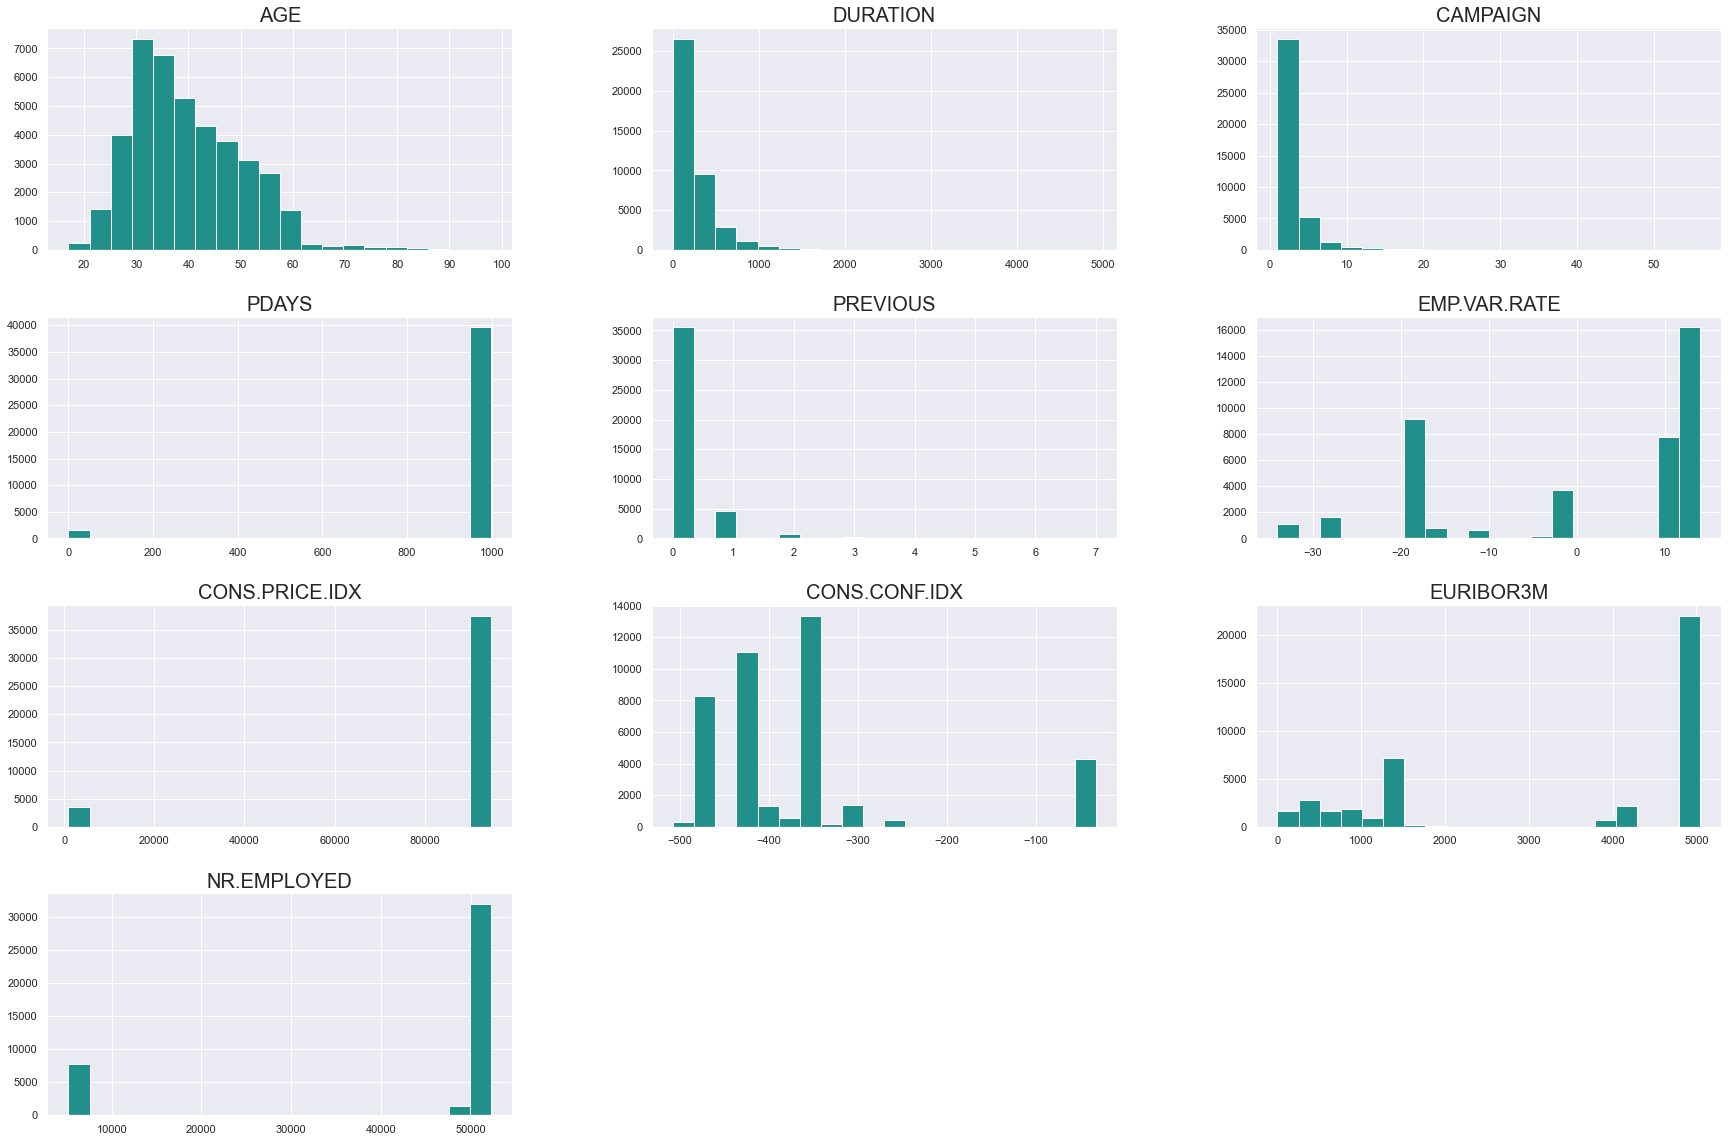

In [8]:
#Histogram for numeric variables
nrows, ncols, counter = 4, 3, 0

axes = data[numeric_cols].hist(layout=(nrows, ncols), figsize=(30,20), bins=20, color=(33/256,145/256,140/256))
for i in range(nrows): 
    for j in range(ncols):
        if counter < len(numeric_cols):
            col = numeric_cols[counter]
            axes[i, j].set_title(col, fontsize=20)
            counter += 1
        else: break
img_name = r'\Histogram for numeric variables_before'
plt.savefig(f'{path_for_save}{img_name}.jpg', dpi=800)
plt.show()

### 1.4.2 - Box-plot against target for numeric variables

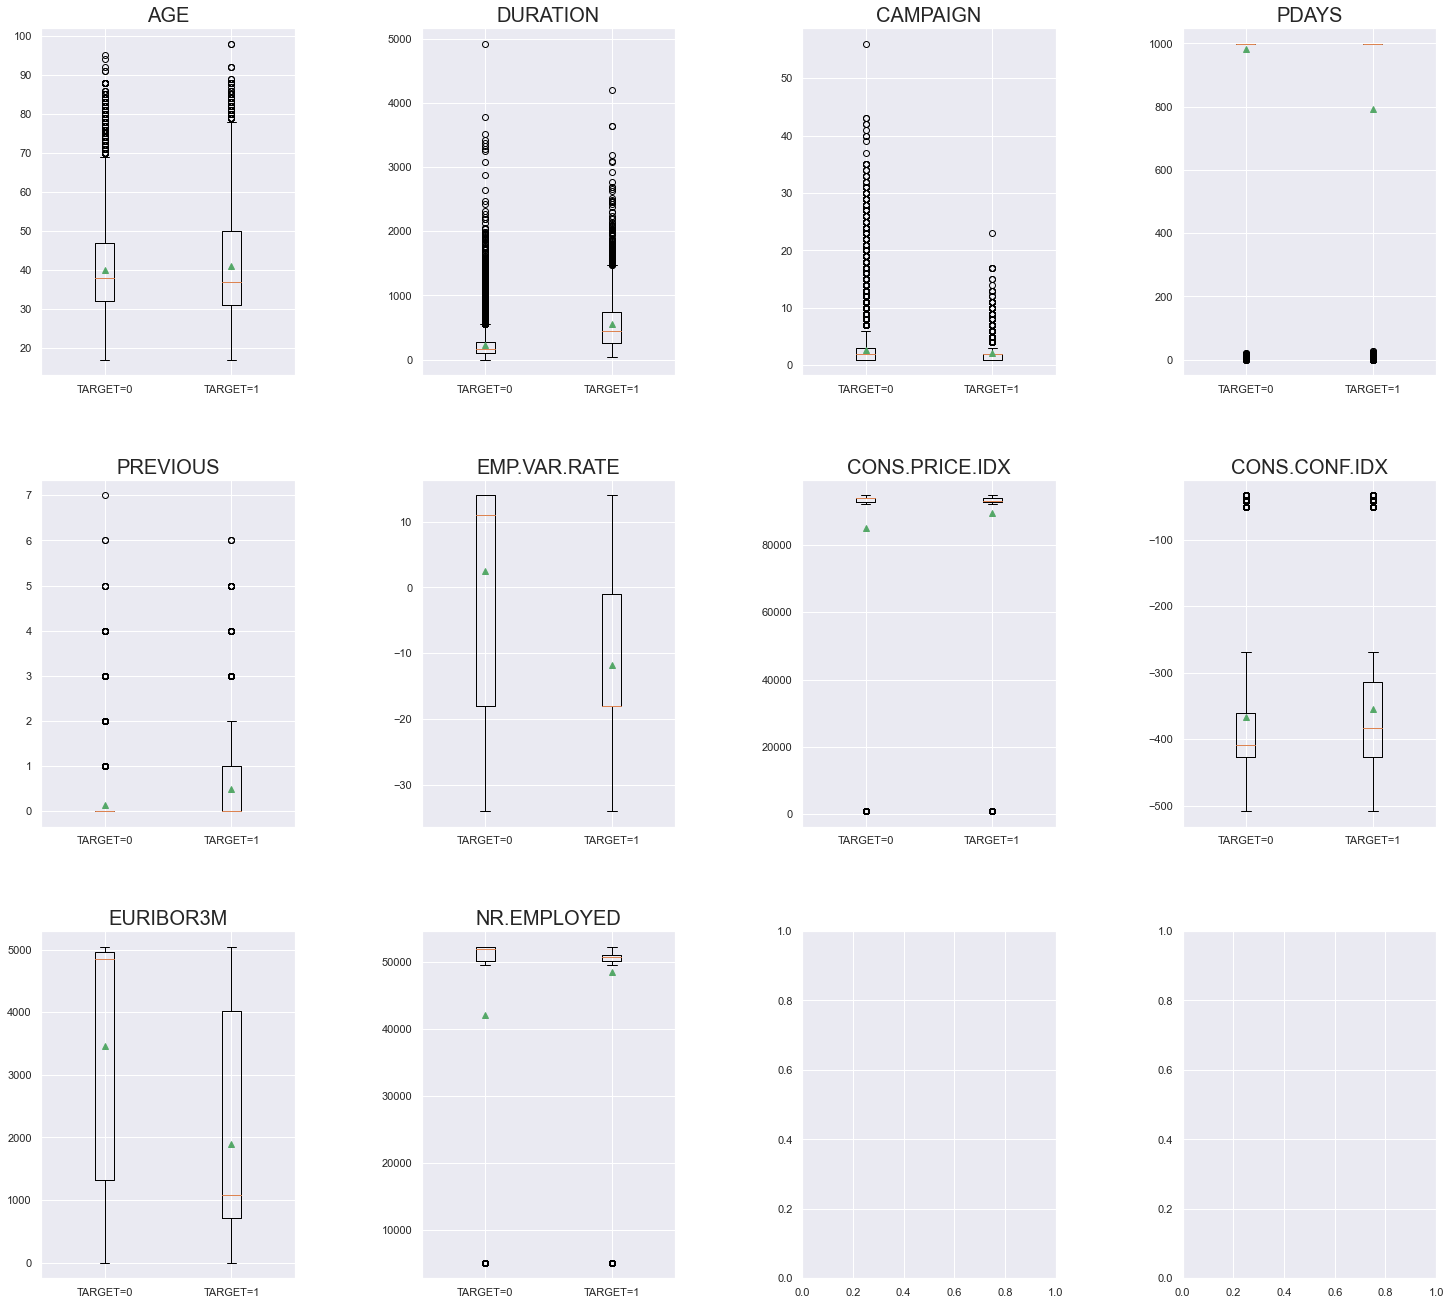

In [9]:
#Box-plot para cada predictor com o TARGET
nrows = 3
ncols = 4
counter = 0

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,23))
for i in range(nrows):
    for j in range(ncols):
        if counter < len(numeric_cols):
            col = numeric_cols[counter]  
            TARGET0 = data[data['TARGET']==0][col]
            TARGET1 = data[data['TARGET']==1][col]
            ax[i, j].boxplot(x=[TARGET0, TARGET1], labels=('TARGET=0','TARGET=1'), showmeans=True)
            ax[i, j].set_title(col.upper(), fontsize=20)
            counter += 1
        else: break
img_name = r'\Box-plot_before'
plt.savefig(f'{path_for_save}{img_name}.jpeg', dpi=800)
plt.subplots_adjust(wspace=0.5, hspace=0.3)

### 1.4.3 - Student's t-test for inference about means of each predictor on classes of the TARGET

In [10]:
#Separando a base em dois grupos: que fez e quem não fez o investimento
data_0 = data[numeric_cols][data['TARGET']== 0] #Grupo que não fez o investimento
data_1 = data[numeric_cols][data['TARGET']== 1] #Grupo que fez o investimento
print('Number of samples for each class')
print('Shape data_0', data_0.shape)
print('Shape data_1', data_1.shape)

Number of samples for each class
Shape data_0 (36548, 10)
Shape data_1 (4640, 10)


In [11]:
# Teste t de Student para igualdade de médias (supondo amostras independentes e variâncias iguais)
# H0: as médias são iguais, portanto não há diferença entre os grupos.
# H1: as médias são diferentes, indicando que há diferença entre os grupos, na variável em questão.

results = pd.DataFrame(columns = ['Variável','Estatística do teste','p-value', 'Resultado'], 
                         index = np.arange(data.shape[1]))

threshold = 0.05

for i, (varn, vary) in enumerate(zip(data_0, data_1)):
    t_test = stats.ttest_ind(data_0[varn], data_1[vary], equal_var=False) 
    if t_test[1] <= threshold:
        result = "Rejeita H0"
    else:
        result = "Aceita H0"
    
    results.iloc[i,0] = varn #Nome da variável
    results.iloc[i,1] = round(t_test[0], 3) #Estatística do teste
    results.iloc[i,2] = round(t_test[1], 3) #p-value
    results.iloc[i,3] = result

results.to_excel(f'{path_for_save}/student test before.xlsx', sheet_name='student test before')
results[:10]

,Variável,Estatística do teste,p-value,Resultado
0,AGE,-4.78,0,Rejeita H0
1,DURATION,-55.5,0,Rejeita H0
2,CAMPAIGN,20.249,0,Rejeita H0
3,PDAYS,32.251,0,Rejeita H0
4,PREVIOUS,-28.126,0,Rejeita H0
5,EMP.VAR.RATE,57.822,0,Rejeita H0
6,CONS.PRICE.IDX,-15.203,0,Rejeita H0
7,CONS.CONF.IDX,-6.098,0,Rejeita H0
8,EURIBOR3M,56.388,0,Rejeita H0
9,NR.EMPLOYED,-35.752,0,Rejeita H0


### 1.4.4 - Correlation analysis of numeric variables

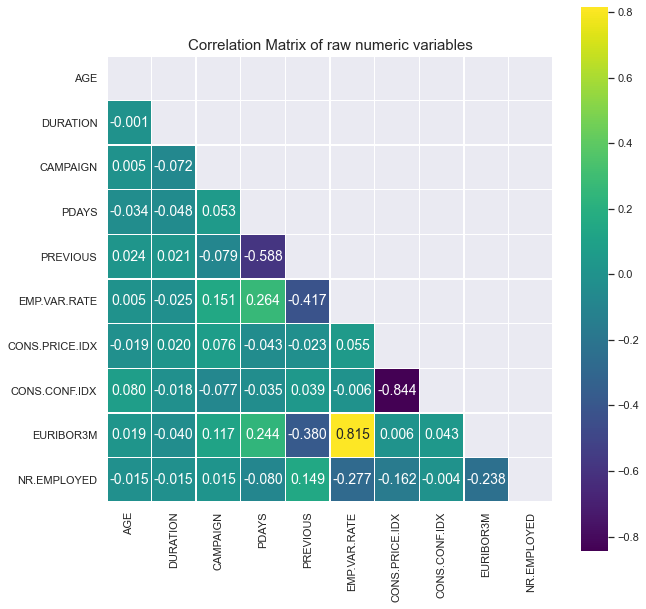

In [12]:
plt.figure(figsize=(10,10))
annot_kws={'fontsize':14}
low_matrix = np.triu(data[numeric_cols].corr())
ax = sns.heatmap(data[numeric_cols].corr(), annot=True, fmt='.3f', cmap='viridis', square=True, linewidths=.5, mask=low_matrix, annot_kws=annot_kws)
plt.title('Correlation Matrix of raw numeric variables', fontsize=15);
img_name = r'\Correlations_before'
plt.savefig(f'{path_for_save}{img_name}.jpeg', dpi=1600)

## 1.5 - Categoric variables

### 1.5.1 - Distribution of classes on categoric variables 

In [13]:
info = pd.DataFrame(data.dtypes)
categoric_cols = [i for i in info.index if info.loc[i][0] == 'object']
print('Categoric variables: ', 'len=', len(categoric_cols), categoric_cols)
print()

for col in categoric_cols:
    ind = data[col].value_counts().index
    val = data[col].value_counts().values
    var_object = pd.DataFrame(data={'Values':ind, 'Qtde':val})
    var_object['Pct'] = [v/var_object['Qtde'].sum() for v in var_object['Qtde']]


Categoric variables:  len= 10 ['JOB', 'MARITAL', 'EDUCATION', 'DEFAULT', 'HOUSING', 'LOAN', 'CONTACT', 'MONTH', 'DAY_OF_WEEK', 'POUTCOME']



### 1.5.2 - Analyze categoric variables and its relation with TARGET variable

In [14]:
chi_sqr_results = pd.DataFrame()
categoric_cols

['JOB',
 'MARITAL',
 'EDUCATION',
 'DEFAULT',
 'HOUSING',
 'LOAN',
 'CONTACT',
 'MONTH',
 'DAY_OF_WEEK',
 'POUTCOME']

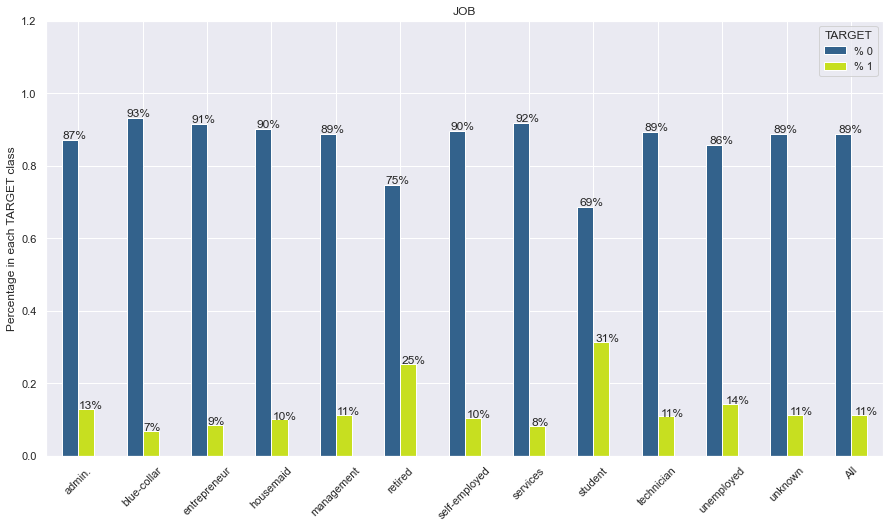

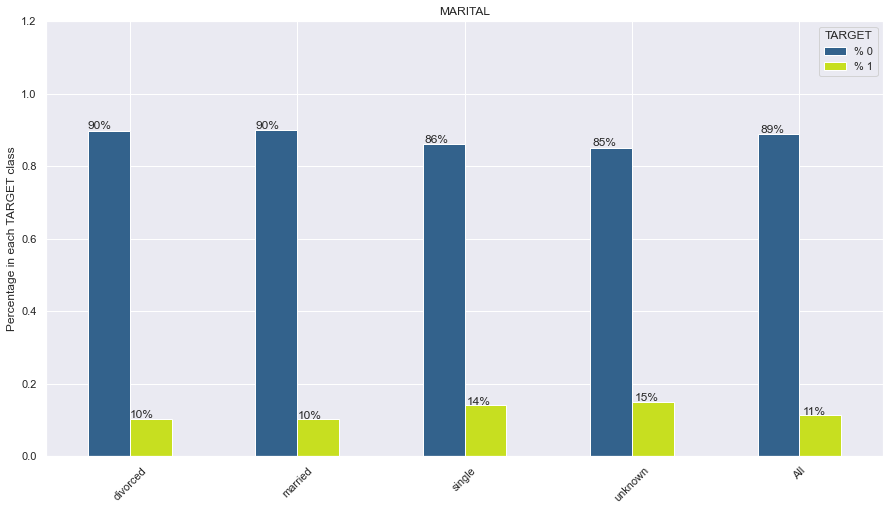

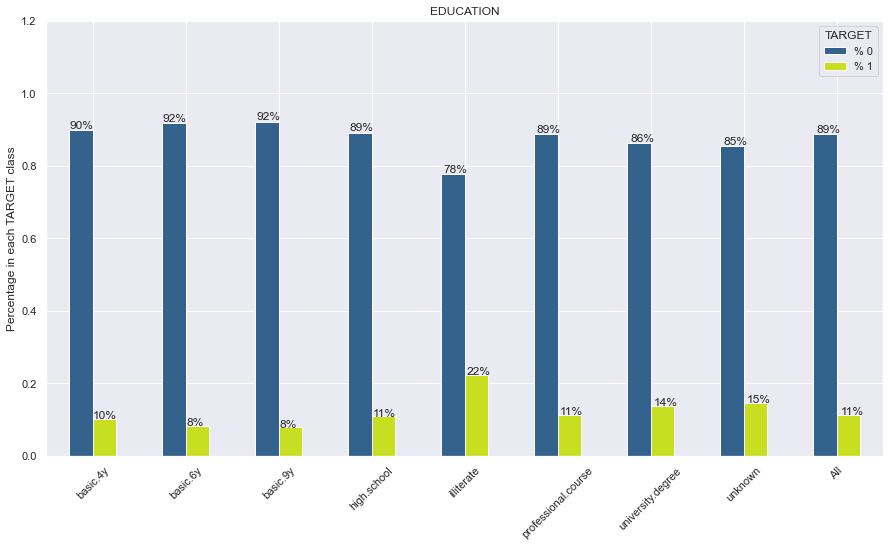

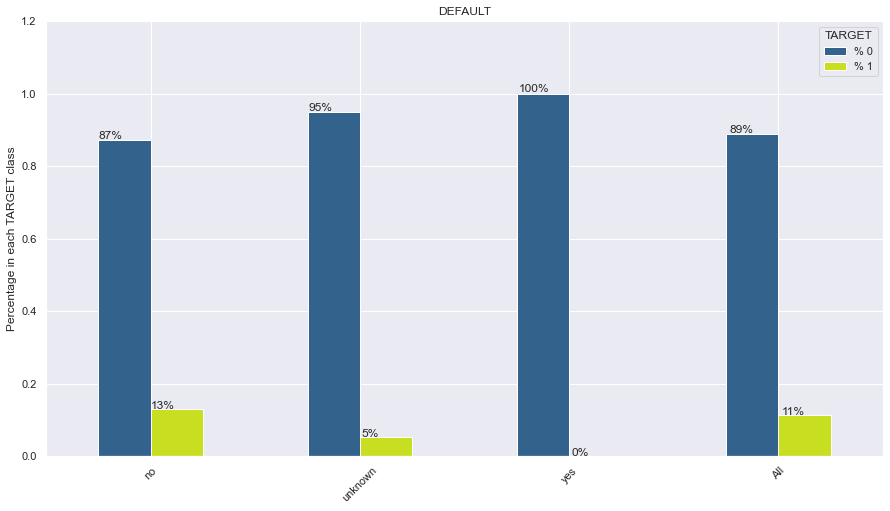

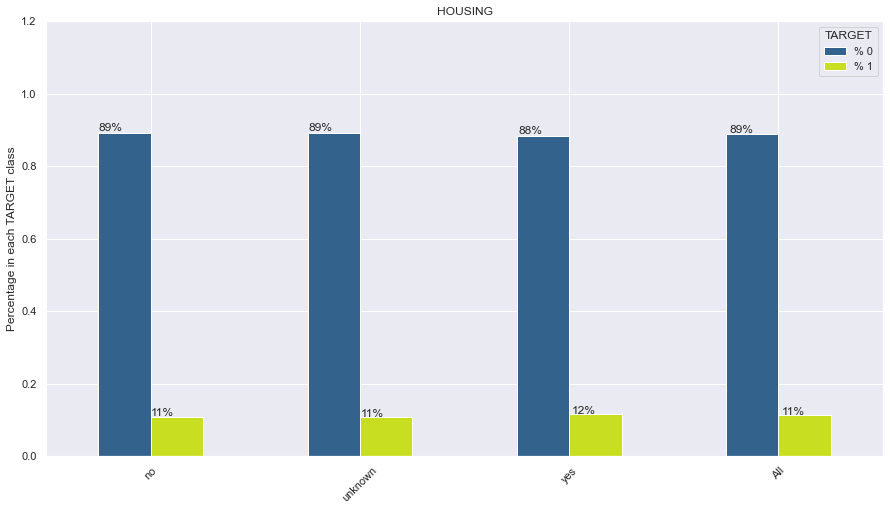

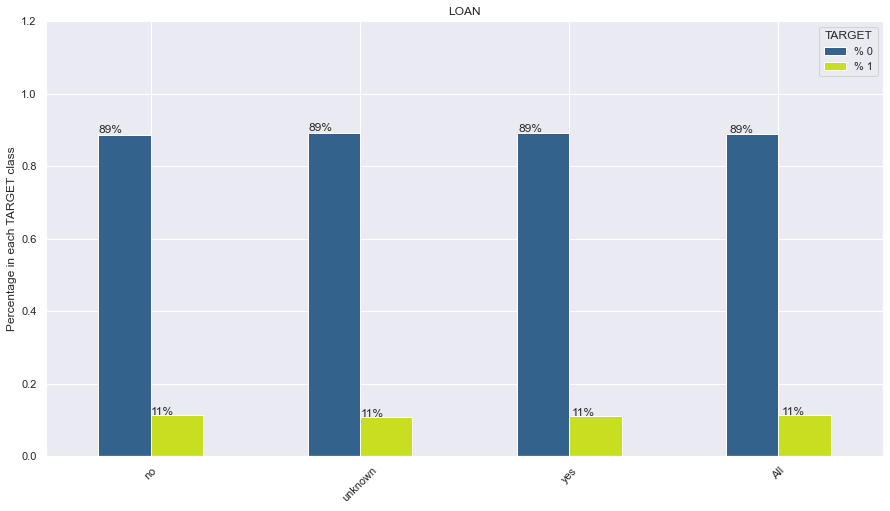

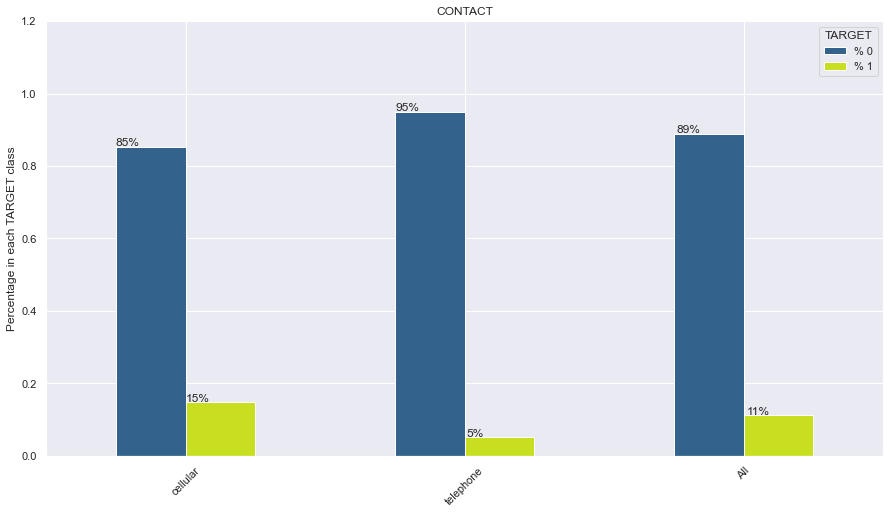

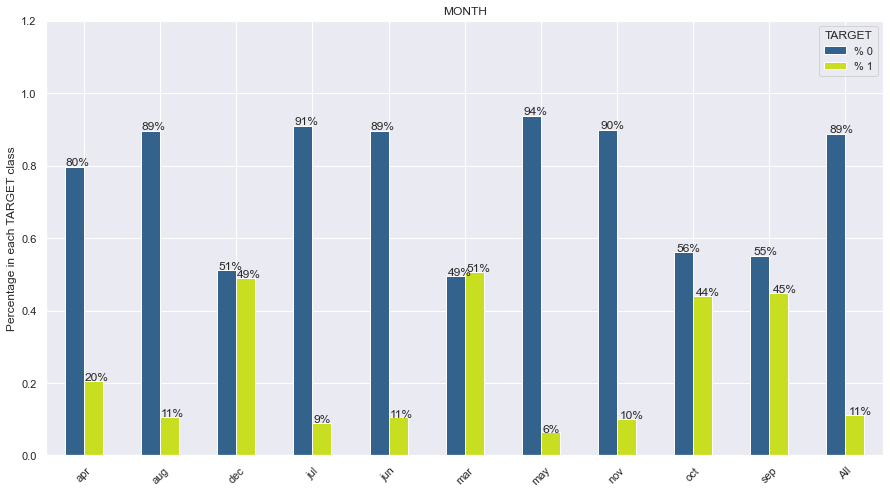

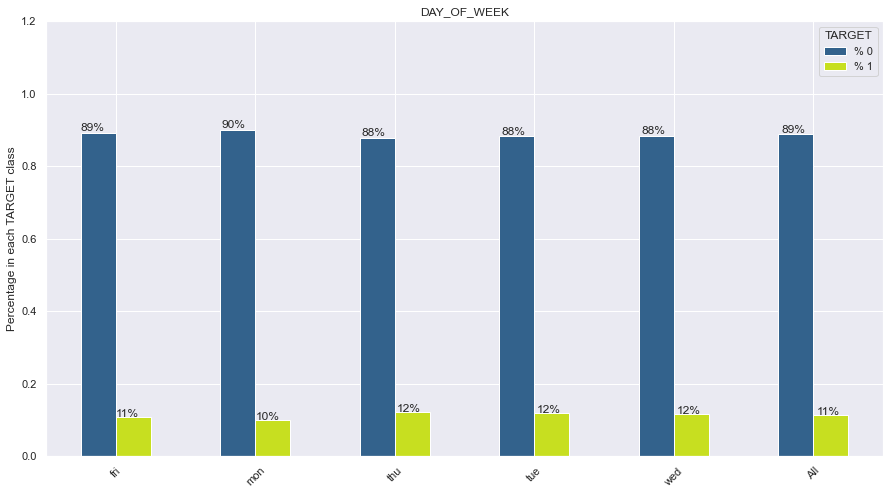

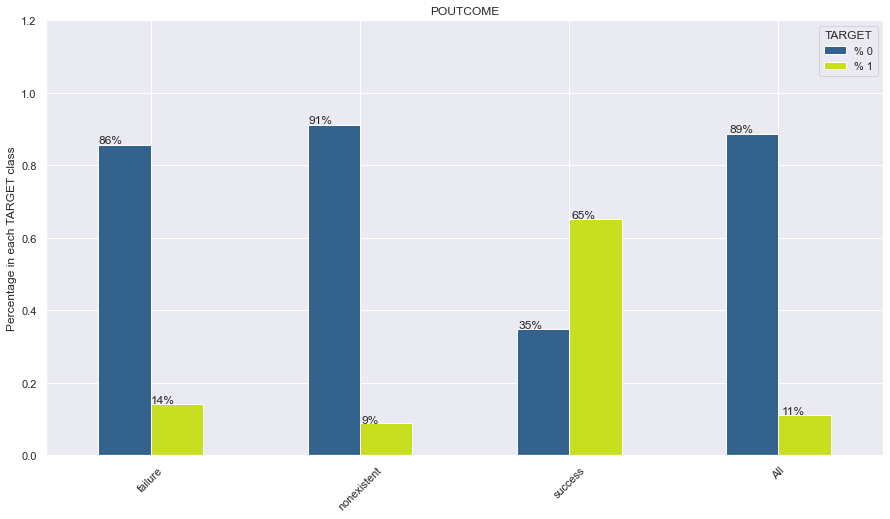

In [15]:
for cat_var in categoric_cols:
    #Chi Square test for testing for TARGET diferences among categories of JOB variable
    #HO: there is no impact of this variable on TARGET (no difference of distributions)
    contigency= pd.crosstab(data.TARGET, data[cat_var], normalize='columns') 
    c, p, dof, expected = chi2_contingency(contigency)
    alpha = 0.05
    result = 'Rejeita HO' if (p <= alpha) else 'Aceita H0'
    table= pd.Series({'Chi Square statistic':round(c, 3), 'p-value':round(p, 3), 'Degrees of Freedom':dof, 'Result':result})
    chi_sqr_results[cat_var] = table

    #Plotting for visualize diferences on the TARGET proportion among categories
    #Preparing data
    df = pd.crosstab(data[cat_var], data.TARGET, margins=True)
    df['% 0'] = df[0]/df['All']
    df['% 1'] = df[1]/df['All']  

    #Plotting
    ax  = df.iloc[:, 3:5].plot.bar(rot=45, figsize=(15,8), title=cat_var, ylim=(0,1.2), 
                               color={'% 0': (51/256, 98/256, 141/256), '% 1': (200/256, 224/256, 32/256)}, xlabel = '',
                               ylabel='Percentage in each TARGET class', stacked=False);
    for p in ax.patches:
        ax.annotate(str(format(p.get_height(), '.0%')), (p.get_x() * 1.005, p.get_height() * 1.005))

    #Save for file
    img_name = f'\{cat_var}_before'
    plt.savefig(f'{path_for_save}{img_name}.jpeg', dpi=1600)

In [16]:
#Print results of Chi Square tests within all categoric variables
chi_sqr_results.to_excel(f'{path_for_save}/chi_sqr_results test before.xlsx', sheet_name='chi sqr results')
chi_sqr_results

,JOB,MARITAL,EDUCATION,DEFAULT,HOUSING,LOAN,CONTACT,MONTH,DAY_OF_WEEK,POUTCOME
Chi Square statistic,0.513,0.017,0.138,0.149,0,0,4.556,1.699,0.003,0.929
p-value,1,0.999,1,0.928,1,1,0.033,0.995,1,0.628
Degrees of Freedom,11,3,7,2,2,2,1,9,4,2
Result,Aceita H0,Aceita H0,Aceita H0,Aceita H0,Aceita H0,Aceita H0,Rejeita HO,Aceita H0,Aceita H0,Aceita H0


# 2 - Data Wrangling

## 2.1 - Feature selection

From the EDA stage we select predictors of interest.

In [17]:
data.columns

Index(['AGE', 'JOB', 'MARITAL', 'EDUCATION', 'DEFAULT', 'HOUSING', 'LOAN',
       'CONTACT', 'MONTH', 'DAY_OF_WEEK', 'DURATION', 'CAMPAIGN', 'PDAYS',
       'PREVIOUS', 'POUTCOME', 'EMP.VAR.RATE', 'CONS.PRICE.IDX',
       'CONS.CONF.IDX', 'EURIBOR3M', 'NR.EMPLOYED', 'TARGET'],
      dtype='object')

In [18]:
selected_predictors = ['DURATION', 'EURIBOR3M','CONS.CONF.IDX' 
                       ,'JOB', 'DEFAULT', 'CONTACT', 'MONTH', 'POUTCOME', 'TARGET']
# Obs.TARGET is not a predictor

## 2.1 - Split train and test sets

In [19]:
#Preparing data - 20% para teste
data_new = data[selected_predictors]
#data_new = data_new.sample(frac=0.1, replace=False, random_state=1) 
X = data_new[data_new.columns[:-1]].copy()
y = data_new[data_new.columns[-1:]].copy()
print('X shape', X.shape)
print('y shape', y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

zeros_train = y_train[y_train['TARGET']==0].count() / y_train['TARGET'].count()
ones_train = y_train[y_train['TARGET']==1].count() / y_train['TARGET'].count()
zeros_test = y_test[y_test['TARGET']==0].count() / y_test['TARGET'].count()
ones_test = y_test[y_test['TARGET']==1].count() / y_test['TARGET'].count()

print('X_train Shape = ', X_train.shape, ' % 0 = ', zeros_train, ' % 1 = ', ones_train)
print('X_test Shape = ', X_test.shape, ' % 0 = ', zeros_test, ' % 1 = ', ones_test)
print('y_train shape', y_train.shape)
print('y_test shape' ,y_test.shape)



X shape (41188, 8)
y shape (41188, 1)
X_train Shape =  (32950, 8)  % 0 =  TARGET    0.887557
dtype: float64  % 1 =  TARGET    0.112443
dtype: float64
X_test Shape =  (8238, 8)  % 0 =  TARGET    0.886502
dtype: float64  % 1 =  TARGET    0.113498
dtype: float64
y_train shape (32950, 1)
y_test shape (8238, 1)


## 2.2 - Transformation, convertions and scaling

In [20]:
cols_to_transform = ['DURATION', 'EURIBOR3M', 'CONS.CONF.IDX']
cols_to_scale = ['DURATION', 'EURIBOR3M', 'CONS.CONF.IDX']

### 2.2.1 - Transformation of continuous variables 

In [21]:
# Function for transforming data

def func_transform(X_train, X_test, list_of_cols_to_transform):
    for data_set in [X_train, X_test]:
        for col in data_set.columns:
            if col in list_of_cols_to_transform:
                col_to_transform = np.array(data_set[col])
                #col_transformed = np.log(col_to_transform + 0.001)
                col_transformed = np.sqrt(col_to_transform + np.abs(np.min(col_to_transform))) 
                #col_transformed = col_to_transform**(1/3)
                #col_transformed = 1/col_to_transform 
                data_set.loc[:, col] = col_transformed
    return X_train, X_test

### 2.2.2 - Convert text variables to numeric

In [22]:
# Function to convert text variables to numeric

def func_convert_to_numeric(X_train, X_test):
    for data_set in [X_train, X_test]: 
        
        #Convert 'job' to numeric
        jobs_to_one = ['student', 'retired']
        rule1 = {j: 1 for j in data_set['JOB'].unique() if j in jobs_to_one}
        rule2 = {j: 0 for j in data_set['JOB'].unique() if j not in jobs_to_one}
        rule = {**rule1, **rule2} #Concat two dicts
        data_set['JOB'].replace(to_replace=rule, inplace=True)

        #Convert 'default' to numeric
        rule = {'no':1, 'yes':0, 'unknown':0}
        data_set['DEFAULT'].replace(to_replace=rule, inplace=True)
        
        #Convert 'contact' to numeric
        rule = {'cellular':1, 'telephone':0}
        data_set['CONTACT'].replace(to_replace=rule, inplace=True)  
        
        #Convert 'month' to numeric, join with orginal data and remove object column
        months_to_one = ['dec','mar','oct','sep']
        rule1 = {m : 1 for m in data_set['MONTH'].unique() if m in months_to_one}
        rule2 = {m : 0 for m in data_set['MONTH'].unique() if m not in months_to_one}
        rule = {**rule1, **rule2} #Concat two dicts
        data_set['MONTH'].replace(to_replace=rule, inplace=True)

        #Convert 'poutcome' to numeric
        rule = {'nonexistent':0, 'failure':0, 'success':1}
        data_set['POUTCOME'].replace(to_replace=rule, inplace=True)  
    
    return X_train, X_test


### 2.2.3 - Feature scaling of some predictors

In [23]:
# Function for standardize some variables

def func_std_scaler(X_train, X_test, cols_to_scale):
    for c in cols_to_scale:
        #Compute standardization
        var_mean = X_train[c].mean()
        var_std = X_train[c].std()
        var_norm_X_train = (X_train[c] - var_mean)/var_std
        var_norm_X_test = (X_test[c] - var_mean)/var_std
        #Drop raw variables
        X_train.drop(c, axis=1)
        X_test.drop(c, axis=1)
        #Assign standardized varibles to data frames
        X_train[c] = var_norm_X_train
        X_test[c] = var_norm_X_test       
        #X_train.loc[:, c] = (X_train[c] - m)/s
        #X_test.loc[:, c] = (X_test[c] - m)/s
    return X_train, X_test

test = func_std_scaler(X_train, X_test, cols_to_scale)

C:\Users\ramon\Anaconda3\envs\MBA\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ramon\Anaconda3\envs\MBA\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### 2.2.4 - Execute transformation, conversion and scaling

In [24]:
#Function for call alt transformations - all sets                         
def func_pipeline(X_train, X_test):
    functions = [
                 func_transform(X_train, X_test, cols_to_transform),
                 func_convert_to_numeric(X_train, X_test),      
                 func_std_scaler(X_train, X_test, cols_to_scale)
                ]       
    for func in functions:
        X_train_prepared, X_test_prepared = X_train, X_test
    return X_train_prepared, X_test_prepared 
    
# Call transformations and rename data sets to better identify them before and after transformations
X_train_prepared, X_test_prepared = func_pipeline(X_train, X_test)

C:\Users\ramon\Anaconda3\envs\MBA\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\ramon\Anaconda3\envs\MBA\lib\site-packages\pandas\core\series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\Users\ramon\Anaconda3\envs\MBA\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [25]:
print()
print(X_train_prepared.info())
print()
print(X_test_prepared.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32950 entries, 12556 to 15795
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DURATION       32950 non-null  float64
 1   EURIBOR3M      32950 non-null  float64
 2   CONS.CONF.IDX  32950 non-null  float64
 3   JOB            32950 non-null  int64  
 4   DEFAULT        32950 non-null  int64  
 5   CONTACT        32950 non-null  int64  
 6   MONTH          32950 non-null  int64  
 7   POUTCOME       32950 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 2.3 MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8238 entries, 32884 to 1871
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DURATION       8238 non-null   float64
 1   EURIBOR3M      8238 non-null   float64
 2   CONS.CONF.IDX  8238 non-null   float64
 3   JOB            8238 non-null   int64  
 4   DEFAULT     

## 2.6 - Descriptive statistics after all data wrangling (training set)

In [26]:
descriptive_after = round(X_train_prepared.describe().T, 3)
descriptive_after.to_excel(f'{path_for_save}/descriptive after.xlsx', sheet_name='descriptive after')
descriptive_after 

,count,mean,std,min,25%,50%,75%,max
DURATION,32950.0,0.000,1.000,-2.202,-0.681,-0.187,0.484,8.362
EURIBOR3M,32950.0,0.000,1.000,-2.618,-0.868,0.791,0.828,0.857
CONS.CONF.IDX,32950.0,0.000,1.000,-2.616,-0.505,-0.212,0.228,2.496
JOB,32950.0,0.063,0.243,0.000,0.000,0.000,0.000,1.000
DEFAULT,32950.0,0.792,0.406,0.000,1.000,1.000,1.000,1.000
CONTACT,32950.0,0.635,0.481,0.000,0.000,1.000,1.000,1.000
MONTH,32950.0,0.049,0.216,0.000,0.000,0.000,0.000,1.000
POUTCOME,32950.0,0.033,0.179,0.000,0.000,0.000,0.000,1.000


## 2.7 - Correlation analysis after all data wrangling (training set)

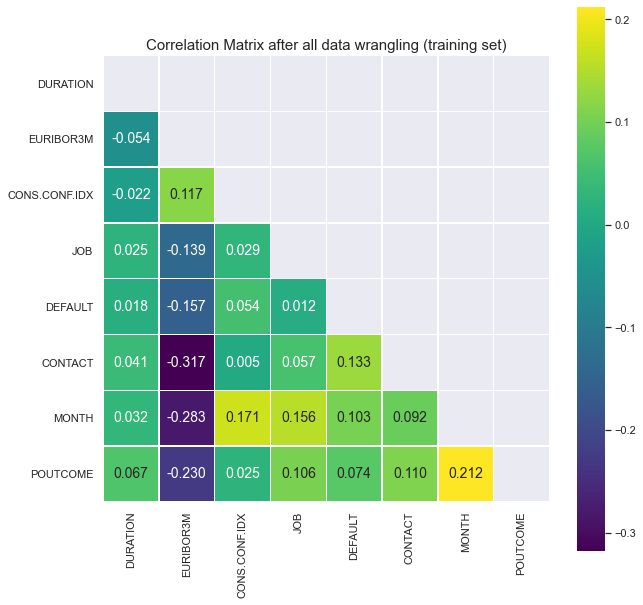

In [27]:
plt.figure(figsize=(10,10))
annot_kws={'fontsize':14}
low_matrix = np.triu(X_train_prepared.corr())
ax = sns.heatmap(X_train_prepared.corr(), annot=True, fmt='.3f', cmap='viridis', square=True, linewidths=.5, mask=low_matrix, annot_kws=annot_kws)
plt.title('Correlation Matrix after all data wrangling (training set)', fontsize=15);
img_name = r'\Correlations_after'
plt.savefig(f'{path_for_save}{img_name}.jpeg', dpi=1600)

## 2.8 - Graphical analysis of remained predictors

### 2.8.1 - Histogram of numerical variables

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

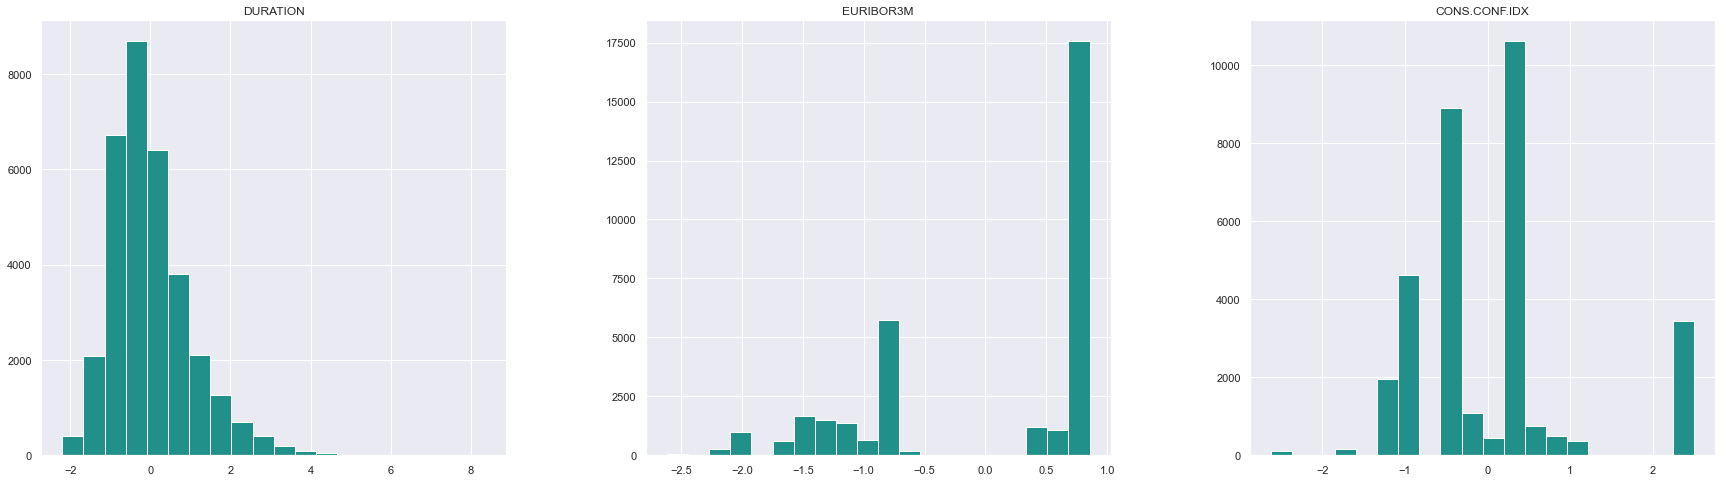

In [43]:
nrows, ncols, counter = 1, 3, 0
cols = X_train_prepared.columns[:3]
axes = X_train_prepared[cols].hist(layout=(nrows, ncols), figsize=(30,8), bins=20, color=(33/256,145/256,140/256))
      
for i, col in enumerate(cols): 
    if counter < len(cols):
        col = X_train_prepared.columns[counter]
        axes[i].set_title(col, fontsize=20)
        counter += 1
    else: break
            
img_name = r'\Histogram for numeric variables_after'
plt.savefig(f'{path_for_save}{img_name}.jpg', dpi=800)
plt.show()

### 2.8.1 - Graphs of categoric variables

In [ ]:

labels = 'Zeros', 'Ones'
sizes = [15, 30, 45, 10]
explode = (0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(layout=(2,3), figsize=(30,20))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## 2.9 - Box-Plot against the TARGET for the final predictors (training set)

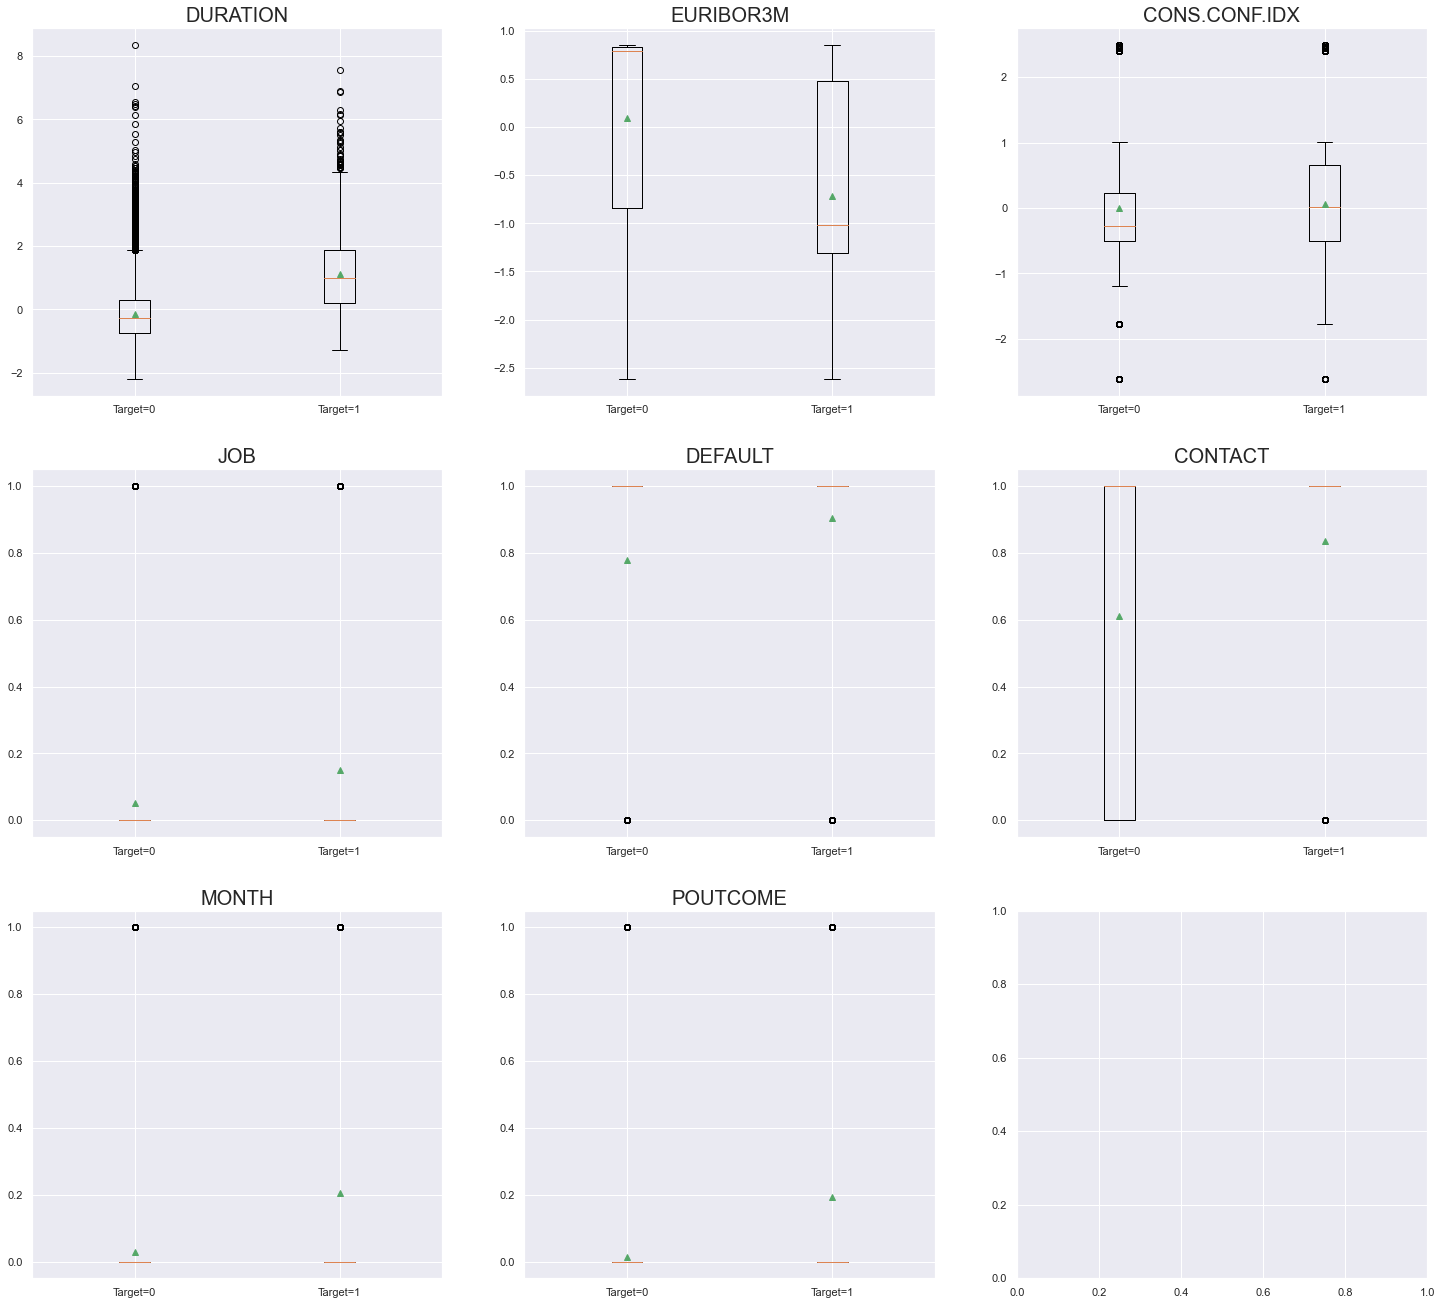

In [65]:
#Box-plot para cada predictor com o TARGET
nrows, ncols, counter = 3, 3, 0

final_predictors = X_train_prepared.columns
final_data = X_train_prepared.join(y_train, how='outer')

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25,23))
for i in range(nrows):
    for j in range(ncols):
        if counter < len(final_predictors):
            col = final_predictors[counter]  
            target0 = final_data[final_data['TARGET']==0][col]
            target1 = final_data[final_data['TARGET']==1][col]
            ax[i, j].boxplot(x=[target0, target1], labels=('Target=0','Target=1'), showmeans=True)
            ax[i, j].set_title(col.upper(), size=20)
            counter += 1
        else: break
            
img_name = r'\Box-plot_after'
plt.savefig(f'{path_for_save}{img_name}.jpeg', dpi=800)            

# 3 - Modelling

### 3.1 - Logistic Regression (Baseline model)

In [66]:
#Baseline classifier 
from sklearn.linear_model import LogisticRegression

#Model selection methods
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#Performance metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import jaccard_score
from imblearn.metrics import geometric_mean_score

from scipy import stats

In [67]:
# Raveling TARGET sets
#y_train =  y_train.ravel()
#y_test = y_test.ravel()
print(y_train.shape)
print(y_test.shape)
y_train =  y_train.to_numpy(copy=True).ravel()
y_test = y_test.to_numpy(copy=True).ravel()

#Define the baseline model (no hyperparameters)
LR = LogisticRegression() 
LR.fit(X_train_prepared, y_train)

#Since whe are not interested in compare diferent raw models, whe do not load cross_val_score
#LR_scores = cross_val_score(LR, X_test_prepared, y_test, cv=rskf, scoring='roc_auc', n_jobs=-1)

#Set some parameters for GridSearch with Logistic Regression
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = [{'penalty': ['none'], 'solver':['newton-cg', 'lbfgs', 'sag','saga']},
              {'penalty': ['l1'], 'C': [0.1, 1, 10, 100, 1000], 'solver':['liblinear', 'saga']},
              {'penalty': ['l2'], 'C': [0.1, 1, 10, 100, 1000], 'solver':['newton-cg', 'lbfgs', 'sag', 'saga']}]

#Define and fit GridSearch function with ross-validation
grid_search = GridSearchCV(LR, param_grid, cv=rskf, scoring='roc_auc', return_train_score=True)
grid_search.fit(X_train_prepared, y_train)
LR_best_model = grid_search.best_estimator_
print('LR Best parameters: ', grid_search.best_params_)

#Evaluate the best model in the test set
y_pred = LR_best_model.predict(X_test_prepared)
probs = LR_best_model.predict_proba(X_test_prepared)
print(len(y_pred))
print(len(probs))
print(X_test_prepared.shape)
     
#Main Metrics
def some_metrics(cm):
    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    ACC = (TP + TN)/(TP + TN + FP + FN)
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    CSI = TP/(TP + FP + FN)
    GS = (TP*TN - FP*FN)/((FN + FP)*(TP + FP + FN + TN) + (TP*TN - FP*FN))
    SSI = TP/(TP + 2*FP + 2*FN)
    FAITH = (TP + 0.5*TN)/(TP + FP + FN + FN)
    PDIF = (4*FP*FN)/(TP + FP + FN + TN)**2
    return ACC, TPR, TNR, CSI, GS, SSI, FAITH, PDIF

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Threshold')
    plt.legend(labels=['Precision', 'Recall'], loc='best')
    plt.title('Precision-Recall Curve - LR')
    
cm = confusion_matrix(y_test, y_pred)
sm = some_metrics(cm)

#Precision-Recall Curve (Géron 2019, pg 143)
#precisions, recalls, thresholds = precision_recall_curve(y_test, probs)
#plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.show()

#Save image for file
img_name = r'\baseline log reg precision recall'
plt.savefig(f'{path_for_save}{img_name}.jpeg', dpi=1600) 

#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1.2])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')

img_name = r'\baseline roc curve_before'
plt.savefig(f'{path_for_save}{img_name}.jpeg', dpi=1600)     
    
plot_roc_curve(fpr, tpr)
plt.show()

(32950, 1)
(8238, 1)
LR Best parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
8238
8238
(8238, 8)


ValueError: y should be a 1d array, got an array of shape (8238, 2) instead.

<Figure size 432x288 with 0 Axes>

In [70]:
#Summarizing the baseline model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as stt

model = sm.Logit(y_train, X_train_prepared) #Defining the model as logistic Regression
results = model.fit() #Fiting the model and creating an instance (object) with the results. Within this object resides
                      #all elements of the summary that can be retrieved separetelly.
summary = results.summary() #Calling the complete table with results
#summary.to_excel(f'{path_for_save}/baseline logistic reg summary.xlsx', sheet_name='summary')
#csvfile = '\baseline logistic reg summary.csv'
#summary.as_csv(f'{path_for_save}{csvfile}')
summary


Optimization terminated successfully.
         Current function value: 0.308813
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                32950
Model:                          Logit   Df Residuals:                    32942
Method:                           MLE   Df Model:                            7
Date:                Wed, 30 Dec 2020   Pseudo R-squ.:                  0.1217
Time:                        23:07:19   Log-Likelihood:                -10175.
converged:                       True   LL-Null:                       -11585.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
DURATION          1.0530      0.018     57.115      0.000       1.017       1.089
EURIBOR3M        -0.8554      0.020    -43.280      0.000      -0.894      -0.817
CONS.CONF.IDX     0.1229      0.019      6.595      0.000       0.086       0.159
JOB               0.1012      0.066      1.531      0.126      -0.028       0.231
DEFAULT          -2.1079      0.033    -63.365      0.000      -2.173      -2.043
CONTACT          -1.2758      0.035    -36.260      0.000      -1.345      -1.207
MONTH             1.2873      0.070     18.460      0.000       1.151       1.424
POUTCOME          2.2345      0.078     28.726      0.000       2.082       2.387
=================================================================================
"""

## 3.2 - Imbalanced models

### 3.2.1 - Import models and define function for performance metrics

In [71]:
#Over-sampling algorithms
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

#Under-sampling algorithms
from imblearn.under_sampling import TomekLinks #https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.TomekLinks.html#imblearn.under_sampling.TomekLinks
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import InstanceHardnessThreshold

#Combination of over- and under-sampling
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

#Ensemble classifiers
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

#Miscelaneous
from collections import Counter

In [72]:
#Metrics
def func_metrics(y_test, y_test_pred, probs, X, y):

    # Summarize the new classes distribution
    lenght = len(X)
    classes_size = sorted(Counter(y).items())
    
    #Metrics native from Scikit Learn
    PRC = precision_score(y_test, y_test_pred) #Precision
    REC = recall_score(y_test, y_test_pred) #Recall, Specificit or True Positive Rate
    F1S = f1_score(y_test, y_test_pred) #F1 Score
    AUC = roc_auc_score(y_test, probs) #ROC auc score   
    
    #Metrics from Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    ACC = (TP + TN)/(TP + TN + FP + FN) #Accuracy
    TPR = TP/(TP + FN) #Sensitivity - Recall - True Positive Rate
    TNR = TN/(TN + FP) #True Negative Rate
    CSI = TP/(TP + FP + FN) #Jaccard Index
    GSS = (TP*TN - FP*FN)/((FN + FP)*(TP + FP + FN + TN) + (TP*TN - FP*FN)) #Gilbert Skill Score 
    SSI = TP/(TP + 2*FP + 2*FN) #Sokal & Sneath Index
    FAITH = (TP + 0.5*TN)/(TP + FP + FN + FN) #Faith Index
    PDIF = (4*FP*FN)/(TP + FP + FN + TN)**2 #Pattern Difference
    
    return lenght, classes_size, ACC, PRC, REC, TNR, TPR, F1S, AUC, CSI, GSS, SSI, FAITH, PDIF 

### 3.2.2 - Defining models and calculate its performance metrics on test set

In [73]:
# Defining models
SMOT = SMOTE()
SVMSMOT = SVMSMOTE()
ADASY = ADASYN()
TOMEK = TomekLinks()
NMISS = NearMiss()
ENN = EditedNearestNeighbours()
RENN = RepeatedEditedNearestNeighbours()
AKNN = AllKNN()
CNN = CondensedNearestNeighbour(sampling_strategy='not minority', random_state=42, n_neighbors=3)
OSS = OneSidedSelection()
NCR = NeighbourhoodCleaningRule()
IHT = InstanceHardnessThreshold()
SMOTET = SMOTETomek()
SMOTEEN = SMOTEENN()
EEC = EasyEnsembleClassifier(n_jobs=-1)
BRFC = BalancedRandomForestClassifier(n_jobs=-1)
RUSBC = RUSBoostClassifier()

models_name = ['SMOTE','SVMSMOTE','ADASYN','TOMEK','NM','ENN','RENN','AllKNN', 'OSS','NCR','IHT','SMOTET','SMOTEENN','EEC','BRFC','RUSBC']
models_instance = [SMOT, SVMSMOT, ADASY, TOMEK, NMISS, ENN, RENN, AKNN, OSS, NCR, IHT, SMOTET, SMOTEEN, EEC, BRFC, RUSBC]

list_models_metrics = ['Model','Set Size','classes_size','ACC','PRC','REC', 'TNR', 'TPR', 'F1S','AUC','CSI','GSS','SSI','FAITH','PDIF']
metrics_panel = pd.DataFrame(columns=list_models_metrics)
time_panel = pd.DataFrame(columns= ['Log Reg', 'Log Reg Tuned'] + models_name)

#Evaluate the Logistic Regression best model in the test set
lr_models = [LR, LR_best_model]
lr_models_name = ['Log Reg', 'Log Reg Tuned']
LR = LogisticRegression() 

start_row = metrics_panel.shape[0]
for row, (model_name, model_instance) in enumerate(zip(lr_models_name, lr_models)):
    start_time = timeit.default_timer()
    model_instance.fit(X_train_prepared, y_train)
    y_test_pred = model_instance.predict(X_test_prepared)
    probs = model_instance.predict_proba(X_test_prepared)[:,1]
    metrics = func_metrics(y_test, y_test_pred, probs, X_test_prepared, y_test)
    for column, metric in enumerate(metrics):
        metrics_panel.loc[row+start_row, 'Model'] = model_name
        metrics_panel.iloc[row+start_row, column+1] = metric       
    end_time = timeit.default_timer()
    total_time = end_time - start_time
    time_panel.loc[0, model_name] = total_time

# Inbalanced methods (over sampling, under sampling and combination of over- and under-sampling)
start_row = metrics_panel.shape[0]
model_lr = lr_models[1] #Using the tuned Logistic Regression Model with ressampled data
for row, (model_name, model_instance) in enumerate(zip(models_name[:13], models_instance[:13])):
    start_time = timeit.default_timer()
    X_resampled, y_resampled = model_instance.fit_resample(X_train_prepared, y_train)  
    model_resampled = model_lr.fit(X_resampled, y_resampled)
    y_test_pred = model_resampled.predict(X_test_prepared) 
    probs = model_resampled.predict_proba(X_test_prepared)[:,1] #Get only positive values 
    cm = confusion_matrix(y_test, y_test_pred)
    metrics = func_metrics(y_test, y_test_pred, probs, X_resampled, y_resampled)
    for column, metric in enumerate(metrics):
        metrics_panel.loc[row+start_row, 'Model'] = model_name
        metrics_panel.iloc[row+start_row, column+1] = metric        
    end_time = timeit.default_timer()
    total_time = end_time - start_time
    time_panel.loc[0, model_name] = total_time
        
#Ensemble Classifiers
start_row = metrics_panel.shape[0]
for row, (model_name, model_instance) in enumerate(zip(models_name[13:], models_instance[13:])):
    model_ressampled = model_instance.fit(X_train_prepared, y_train)
    y_pred = model_ressampled.predict(X_test_prepared) 
    probs = model_resampled.predict_proba(X_test_prepared)[:,1]
    #y_test_pred_geron = cross_val_predict(estimator=model_resampled, X=X_test_prepared, y=y_test, cv=3, n_jobs=-1)
    #y_test_scores = cross_val_predict(estimator=model_ressampled, X=X_test_prepared, y=y_test, cv=5, method="decision_function", n_jobs=-1)  
    metrics = func_metrics(y_test, y_pred, probs, X, y)
    for column, metric in enumerate(metrics):
        metrics_panel.loc[row+start_row, 'Model'] = model_name
        metrics_panel.iloc[row+start_row, column+1] = metric
    end_time = timeit.default_timer()
    total_time = end_time - start_time
    time_panel.loc[0, model_name] = total_time

#Save for file    
metrics_panel.to_excel(f'{path_for_save}/Metrics panel.xlsx', sheet_name='Metrics panel')
time_panel.to_excel(f'{path_for_save}/Time panel.xlsx', sheet_name='Time panel')

### 3.2.3 - Panel of performance metrics

In [74]:
metrics_panel

,Model,Set Size,classes_size,ACC,PRC,REC,TNR,TPR,F1S,AUC,CSI,GSS,SSI,FAITH,PDIF
0,Log Reg,8238,"[(0, 7303), (1, 935)]",0.908473,0.665448,0.389305,0.974942,0.389305,0.491228,0.923766,0.325581,0.285928,0.194444,2.32327,0.00615891
1,Log Reg Tuned,8238,"[(0, 7303), (1, 935)]",0.908837,0.67037,0.387166,0.975626,0.387166,0.490847,0.924002,0.325247,0.285925,0.194206,2.3277,0.00601161
2,SMOTE,58490,"[(0, 29245), (1, 29245)]",0.843044,0.408673,0.856684,0.841298,0.856684,0.553368,0.924347,0.382521,0.309126,0.236492,1.73833,0.00915387
3,SVMSMOTE,58490,"[(0, 29245), (1, 29245)]",0.846443,0.413522,0.84385,0.846775,0.84385,0.555047,0.9241,0.384129,0.311544,0.237722,1.76409,0.0096294
4,ADASYN,58878,"[(0, 29245), (1, 29633)]",0.821923,0.379747,0.898396,0.812132,0.898396,0.533842,0.923957,0.364109,0.286458,0.222576,1.5843,0.00768235
5,TOMEK,31903,"[(0, 28198), (1, 3705)]",0.911508,0.648415,0.481283,0.966589,0.481283,0.552486,0.92418,0.381679,0.337413,0.235849,2.39153,0.00697506
6,NM,7410,"[(0, 3705), (1, 3705)]",0.831391,0.375275,0.730481,0.844311,0.730481,0.495826,0.884968,0.329633,0.255401,0.197342,1.62048,0.016888
7,ENN,29350,"[(0, 25645), (1, 3705)]",0.898883,0.545213,0.657754,0.929755,0.657754,0.596219,0.923919,0.424724,0.368927,0.269619,2.2681,0.00967573
8,RENN,28414,"[(0, 24709), (1, 3705)]",0.891843,0.517002,0.715508,0.914419,0.715508,0.600269,0.923778,0.428846,0.369486,0.27295,2.19496,0.00979892
9,AllKNN,28819,"[(0, 25114), (1, 3705)]",0.894028,0.525162,0.691979,0.919896,0.691979,0.597139,0.923785,0.425658,0.367469,0.270372,2.21571,0.00993035


### 3.2.4 - Panel of time for processing each model

In [75]:
time_panel

,Log Reg,Log Reg Tuned,SMOTE,SVMSMOTE,ADASYN,TOMEK,NM,ENN,RENN,AllKNN,OSS,NCR,IHT,SMOTET,SMOTEENN,EEC,BRFC,RUSBC
0,0.201651,0.160673,0.407189,11.7708,0.539778,0.821268,0.413151,0.809819,4.52486,1.73869,1.83898,2.03872,9.91059,1.36351,1.53858,10.9846,12.8347,14.1401


### 3.2.5 - Feature importance

,Feature importance
DURATION,0.551097
EURIBOR3M,0.206333
CONS.CONF.IDX,0.100448
JOB,0.013368
DEFAULT,0.014174
CONTACT,0.027515
MONTH,0.041358
POUTCOME,0.045707


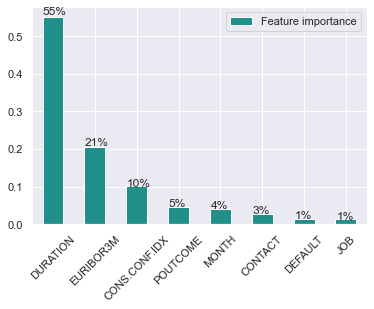

In [76]:
#Generate feature importance from a choose model
model_for_feature_importance = BRFC
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train_prepared.columns, model_for_feature_importance.feature_importances_):
    feats[feature] = importance #add the name/value pair 

#Save feature importance in a data frame and creat a graph
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Feature importance'})
ax = importances.sort_values(by='Feature importance', ascending=False).plot(kind='bar', rot=45, color=(33/256,145/256,140/256))
for p in ax.patches:
    ax.annotate(str(format(p.get_height(), '.0%')), (p.get_x() * 1.005, p.get_height() * 1.010))

#Save for file    
img_name = r'\Feature importance'
plt.savefig(f'{path_for_save}{img_name}.jpg', dpi=1600)

importances

## References
* MCKINNEY, Wes - Python for Data Analysis - O'Reilly - 2018
* GÉRON, Aurelien - Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow - O'Reilly - 2019
* LEMAITRE, Guilhaume. NOGUEIRA, Fernando. ARIDAS, Christos K., Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning, Journal of Machine Learning Research - 2017